In [3]:
# import random
# import sys
# import warnings
from pathlib import Path

# import DataSets_contigs as ds
# import kaplanmeier as km
import matplotlib.pyplot as plt

# import numpy as np
# import optuna
# import pandas as pd
import polars as pl
import _config as cfg
# import pymysql
# from imblearn.over_sampling import SMOTE
# from sklearn import svm
# from sklearn.metrics import (
#     accuracy_score,
#     f1_score,
#     precision_score,
#     recall_score,
#     roc_auc_score,
# )
# from sklearnex import patch_sklearn

# patch_sklearn()
# warnings.filterwarnings("ignore")
# random.seed(1024)
# np.random.seed(1024)

results_dir = Path("Results")
results_dir.mkdir(parents=True, exist_ok=True)

perf_col = "aroc"

perf_delta_col = "performance_delta"
scaffold_old_col = "Id"
scaffold_col = "scaffold"
var_class_col = "Variant_Classification"
prot_change_col = "Protein_Change"

# Matplotlib config
plt.rcdefaults()

main_font_size = 6
label_font_size = 10

axis_color = "0.15"

plt.rcParams["text.color"] = axis_color
plt.rcParams["axes.labelcolor"] = axis_color
plt.rcParams["xtick.color"] = axis_color
plt.rcParams["ytick.color"] = axis_color
plt.rcParams["axes.edgecolor"] = axis_color

plt.rcParams["font.size"] = main_font_size
plt.rcParams["axes.labelsize"] = main_font_size
plt.rcParams["axes.titlesize"] = main_font_size
plt.rcParams["xtick.labelsize"] = main_font_size
plt.rcParams["ytick.labelsize"] = main_font_size
plt.rcParams["legend.fontsize"] = main_font_size
plt.rcParams["figure.labelsize"] = main_font_size
plt.rcParams["figure.titlesize"] = main_font_size

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["savefig.transparent"] = True

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"


def figsize_in_mm(width, height):
    mm = 1 / 25.4  # millimeters in inches
    return (width * mm, height * mm)

In [4]:
# Scaffold level

#
config = cfg.configurations[3]
mut_remove_results_file = results_dir / "mutation-remove-experiments-Scaffold_level.csv"
mut_join_col = scaffold_col
promisc_col = "popcov_but_sqrt"
#

mutset_file = Path(config["contig_file"])
mutset = pl.read_csv(mutset_file, separator="\t", infer_schema_length=50000)
mutset = mutset.rename({scaffold_old_col: scaffold_col})

contigmut = pl.read_csv(mut_remove_results_file)

aroccontigmut = contigmut[perf_col][0]

contig_mutations_with_delta = (
    contigmut.slice(1)
    .with_columns((aroccontigmut - pl.col(perf_col)).alias(perf_delta_col))
    .sort(perf_delta_col, descending=True)
)

# Add model performance info to mutations
mutset = (
    mutset.join(
        contig_mutations_with_delta,
        on=mut_join_col,
        suffix="_dup",
        how="left",
        coalesce=False,
    )
    .filter(pl.col(mut_join_col).is_not_null())
    .sort(perf_delta_col, descending=True)
)
# Is this necessary?
# mutset = mutset.unique(["Chromosome", "Start_position", "End_position"])

In [ ]:
# mutset = pl.read_csv(
#     "../data/Michal_combined_set_14_02_2025.tsv",
#     separator="\t",
#     infer_schema_length=50000,
# )

In [ ]:
# nofeaturemut = pl.read_csv(
#     "../data/Bruan_MutationExperiments_nofeatures*",
#     dtypes={"Start_position": pl.Float64(), "End_position": pl.Float64()},
# ).with_columns(
#     pl.col("Start_position").cast(pl.Int64()), pl.col("End_position").cast(pl.Int64())
# )
# arocnofeaturemut = nofeaturemut["aroc"][0]
# no_feature_mutations_with_delta = (
#     nofeaturemut.with_columns(performance_delta=arocnofeaturemut - pl.col("aroc"))
#     .sort("performance_delta", descending=True)
#     .drop_nulls()
# )
# no_feature_mutations_with_delta = (
#     mutset.join(
#         no_feature_mutations_with_delta,
#         on=["Chromosome", "Start_position", "End_position"],
#         suffix="suffering",
#     )
#     .sort("performance_delta", descending=True)
#     .unique(["Chromosome", "Start_position", "End_position"])
# )

In [ ]:
# contigmut = pl.read_csv(
#     "../data/Bruan_MutationExperiments_contigs.csv",
#     dtypes={"Start_position": pl.Float64(), "End_position": pl.Float64()},
# ).with_columns(
#     pl.col("Start_position").cast(pl.Int64()), pl.col("End_position").cast(pl.Int64())
# )
# aroccontigmut = contigmut["aroc"][0]
# contig_mutations_with_delta = (
#     contigmut.with_columns(performance_delta=aroccontigmut - pl.col("aroc"))
#     .sort("performance_delta", descending=True)
#     .drop_nulls()
# )
# contig_mutations_with_delta = (
#     mutset.join(
#         contig_mutations_with_delta,
#         on=["Chromosome", "Start_position", "End_position"],
#         suffix="suffering",
#     )
#     .sort("performance_delta", descending=True)
#     .unique(["Chromosome", "Start_position", "End_position"])
# )

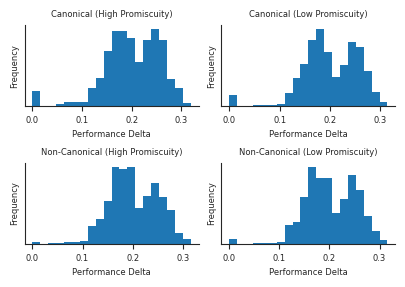

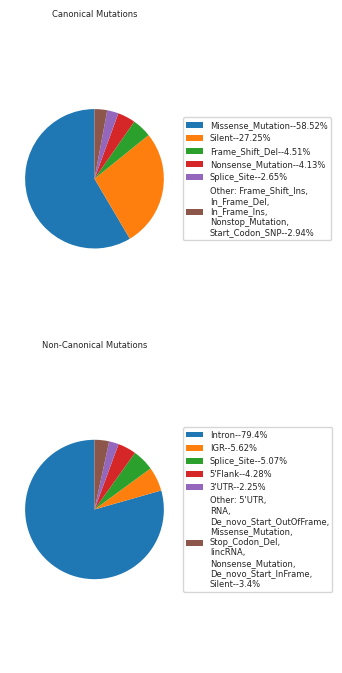

In [166]:
# Performance delta distribution

promisc_boundary = 13

base_df = contig_mutations_with_delta

canonical = base_df.filter(pl.col(prot_change_col).is_not_null())
non_canonical = base_df.filter(pl.col(prot_change_col).is_null())

canonical_high = canonical.filter(pl.col(promisc_col) > promisc_boundary)
canonical_low = canonical.filter(pl.col(promisc_col) <= promisc_boundary)
non_canonical_high = non_canonical.filter(pl.col(promisc_col) > promisc_boundary)
non_canonical_low = non_canonical.filter(pl.col(promisc_col) <= promisc_boundary)

data_subgroups = {
    "Canonical (High Promiscuity)": canonical_high[perf_delta_col],
    "Canonical (Low Promiscuity)": canonical_low[perf_delta_col],
    "Non-Canonical (High Promiscuity)": non_canonical_high[perf_delta_col],
    "Non-Canonical (Low Promiscuity)": non_canonical_low[perf_delta_col],
}

# Fig
fig_size = figsize_in_mm(100, 70)
#
fig, axes = plt.subplots(2, 2, figsize=fig_size, layout="constrained")
for ax, (title, series) in zip(axes.flatten(), data_subgroups.items()):
    ax.hist(series, bins=20, density=True, label="contigs")
    ax.set_title(title)
    ax.set_xlabel("Performance Delta")
    ax.set_ylabel("Frequency")
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.grid(axis="y", alpha=0.5)
for fmt in ["pdf", "png"]:
    fig.savefig(results_dir / f"performance-delta-histograms.{fmt}", dpi=600)

# Variant classifications distribution

base_df = mutset

canonical = base_df.filter(pl.col(prot_change_col).is_not_null())
non_canonical = base_df.filter(pl.col(prot_change_col).is_null())

groups = [
    ("Canonical Mutations", canonical),
    ("Non-Canonical Mutations", non_canonical),
]

# Fig
n_other_groups = [5, 9]
fig_size = figsize_in_mm(70 * 1.2, 140 * 1.2)
#
fig, axes_pie = plt.subplots(2, 1, figsize=fig_size, layout="constrained")
for ax, (title, group_df), n_other in zip(axes_pie.flatten(), groups, n_other_groups):
    counts = group_df.group_by(var_class_col).len().sort("len", descending=True)
    labels = counts[var_class_col]
    sizes = counts["len"]
    n_labels = len(labels)
    if 0 < n_other < n_labels:
        other_sum = sizes.slice(-n_other).sum()
        sizes = sizes.slice(0, n_labels - n_other).append(
            pl.Series("a", [other_sum], dtype=pl.UInt32)
        )
        other_label = "Other: " + ",\n".join(labels.slice(-n_other).to_list())
        labels = labels.slice(0, n_labels - n_other).append(
            pl.Series("a", [other_label])
        )
        n_labels = len(labels)
    elif n_other >= n_labels:
        raise ValueError("Too much labels compressed into 'Other'")
    colors = None
    if n_labels <= 10:
        colors = [plt.color_sequences["tab10"][i] for i in range(n_labels)]
    else:
        colors = plt.color_sequences["tab10"]
        n_l_rest = n_labels - 10
        if n_l_rest <= 8:
            colors += [plt.color_sequences["Set3"][i] for i in range(n_l_rest)]
        else:
            raise ValueError("No colors left, yet")
    wedges, _ = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct=None,
        startangle=90,
        labeldistance=None,
    )
    ax.set_title(title)
    percents = (sizes / sizes.sum() * 100).round(2)
    legend_labels = [f"{lab}--{p}%" for lab, p in zip(labels, percents)]
    ax.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    ax.axis("equal")
for fmt in ["pdf", "png"]:
    fig.savefig(results_dir / f"variant-classifications-pie-charts.{fmt}", dpi=600)

In [ ]:
# canonical = contig_mutations_with_delta.filter(pl.col("Protein_Change").is_not_null())
# non_canonical = contig_mutations_with_delta.filter(pl.col("Protein_Change").is_null())

# canonical_high = canonical.filter(pl.col("popcov_but_sqrt") > 13)
# canonical_low = canonical.filter(pl.col("popcov_but_sqrt") <= 13)
# non_canonical_high = non_canonical.filter(pl.col("popcov_but_sqrt") > 13)
# non_canonical_low = non_canonical.filter(pl.col("popcov_but_sqrt") <= 13)

# canonical_high.write_csv("canonical_high.tsv", separator="\t")
# canonical_low.write_csv("canonical_low.tsv", separator="\t")
# non_canonical_high.write_csv("non_canonical_high.tsv", separator="\t")
# non_canonical_low.write_csv("non_canonical_low.tsv", separator="\t")

# data_subgroups = {
#     "Canonical High": canonical_high["performance_delta"],
#     "Canonical Low": canonical_low["performance_delta"],
#     "Non-Canonical High": non_canonical_high["performance_delta"],
#     "Non-Canonical Low": non_canonical_low["performance_delta"],
# }

# canonical_nf = no_feature_mutations_with_delta.filter(
#     pl.col("Protein_Change").is_not_null()
# )
# non_canonical_nf = no_feature_mutations_with_delta.filter(
#     pl.col("Protein_Change").is_null()
# )

# canonical_high_nf = canonical_nf.filter(pl.col("popcov_but_sqrt") > 13)
# canonical_low_nf = canonical_nf.filter(pl.col("popcov_but_sqrt") <= 13)
# non_canonical_high_nf = non_canonical_nf.filter(pl.col("popcov_but_sqrt") > 13)
# non_canonical_low_nf = non_canonical_nf.filter(pl.col("popcov_but_sqrt") <= 13)

# data_subgroups_nf = {
#     "Canonical High": canonical_high_nf["performance_delta"],
#     "Canonical Low": canonical_low_nf["performance_delta"],
#     "Non-Canonical High": non_canonical_high_nf["performance_delta"],
#     "Non-Canonical Low": non_canonical_low_nf["performance_delta"],
# }

# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# titles = [
#     "Canonical (High Promiscuity)",
#     "Canonical (Low Promiscuity)",
#     "Non-Canonical (High Promiscuity)",
#     "Non-Canonical (Low Promiscuity)",
# ]

# plt.rcParams["pdf.fonttype"] = 42
# plt.rcParams["ps.fonttype"] = 42
# plt.rcParams["svg.fonttype"] = "none"
# for ax, (key, series), (key_nf, series_nf), title in zip(
#     axes.flatten(), data_subgroups.items(), data_subgroups_nf.items(), titles
# ):
#     ax.hist(
#         series_nf,
#         range=(0.0, 0.15),
#         alpha=0.7,
#         density=True,
#         color="tab:green",
#         label="baseline",
#     )
#     ax.hist(
#         series, bins=20, range=(0.0, 0.15), alpha=0.7, density=True, label="contigs"
#     )
#     ax.set_title(title)
#     ax.set_xlabel("Performance Delta")
#     ax.set_ylabel("Frequency")
#     ax.set_yticks([])
#     ax.set_yticklabels([])
#     ax.grid(axis="y", alpha=0.5)
#     ax.legend()

# plt.tight_layout()
# plt.suptitle("Performance Delta Distributions by Group", y=1.02)
# plt.savefig("performance_delta_histograms.pdf")
# plt.show()

# fig, axes = plt.subplots(2, 2, figsize=(18, 12))
# groups = [
#     (canonical, "contig Canonical Mutations"),
#     (canonical_nf, "baseline Canonical Mutations"),
#     (non_canonical, "contig Non-Canonical Mutations"),
#     (non_canonical_nf, "baseline Non-Canonical Mutations"),
# ]
# plt.rcParams["pdf.fonttype"] = 42
# plt.rcParams["ps.fonttype"] = 42
# plt.rcParams["svg.fonttype"] = "none"
# for ax, (group_df, title) in zip(axes.flatten(), groups):
#     counts = (
#         group_df.groupby("Variant_Classification")
#         .count()
#         .sort("count", descending=True)
#     )
#     labels = counts["Variant_Classification"]
#     sizes = counts["count"]

#     ax.pie(
#         sizes,
#         labels=labels,
#         autopct="%1.1f%%",
#         startangle=90,
#         textprops={"fontsize": 8},
#     )
#     ax.set_title(title)
#     ax.legend()
#     ax.axis("equal")

# plt.tight_layout()
# plt.suptitle("Variant Classifications Distribution by Group", y=1.02)
# plt.savefig("variant_classifications_pie_charts.pdf")
# plt.show()